
<p><img align="left" src="https://www.cqf.com/themes/custom/creode/logo.svg" style="vertical-align: top; padding-top: 23px;" width="10%"/>
<img align="right" src="https://upload.wikimedia.org/wikipedia/commons/c/c3/Python-logo-notext.svg" style="vertical-align: middle;" width="12%"/>
<font color="#306998"><h1><center>Python Labs</center></h1></font></p>
<p></p><h1><center>Value At Risk</center></h1>
<center><b>Kannan Singaravelu</b></center>
<center>kannan.singaravelu@fitchlearning.com</center>



<h2 id="Value-at-Risk">Value-at-Risk<a class="anchor-link" href="#Value-at-Risk">¶</a></h2><p>Value at Risk - <strong>VaR</strong> - is one of the most important metrics that is used to measures the risk associated with a financial position or a portfolio of financial instruments. VaR can be defined as the maximum loss with a confidence level over a predetermined period. Let's say that the 1-day 95% VaR of our portfolio is $\$100$. This means that 95% of the time, it is expected that - under normal market conditions - we will not lose more than $100 by holding our portfolio over one day.</p>
<p>Three approaches that are commonly used in the industry are</p>
<ul>
<li><strong>Parametric</strong></li>
<li><strong>Historical Simulation</strong> </li>
<li><strong>Monte Carlo Simulation</strong></li>
</ul>



<h3 id="Import-Libraries">Import Libraries<a class="anchor-link" href="#Import-Libraries">¶</a></h3>


In [1]:

import pandas as pd
import numpy as np
from numpy.linalg import multi_dot

from scipy import stats
from scipy.stats import norm
from tabulate import tabulate

# Import matplotlib for visualization
import matplotlib
import matplotlib.pyplot as plt

# Plot settings
# plt.style.use('dark_background')
matplotlib.rcParams['figure.figsize'] = [24.0, 8.0]
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['lines.linewidth'] = 2.0
# matplotlib.rcParams['grid.color'] = 'black'



<h3 id="Retrieve-Data">Retrieve Data<a class="anchor-link" href="#Retrieve-Data">¶</a></h3><p>We will use the FAANG stocks as before to build for calculation of VaR</p>


In [3]:

# Load locally stored data
df = pd.read_csv('faang_stocks_1.csv', parse_dates=True, index_col=0)['2013':]

# Check first 5 values 
df.head()



,AAPL,AMZN,FB,GOOG,NFLX
Date,,,,,
2019-05-31,43.034817,1775.069946,177.470001,1103.630005,343.279999
2019-06-03,42.599720,1692.689941,164.149994,1036.229980,336.630005
2019-06-04,44.158184,1729.560059,167.500000,1053.050049,353.399994
2019-06-05,44.871044,1738.500000,168.169998,1042.219971,355.730011
2019-06-06,45.529827,1754.359985,168.330002,1044.339966,357.130005



<h3 id="Calculate-Returns">Calculate Returns<a class="anchor-link" href="#Calculate-Returns">¶</a></h3>


In [4]:

# Calculate daily returns
returns = df.pct_change().dropna()



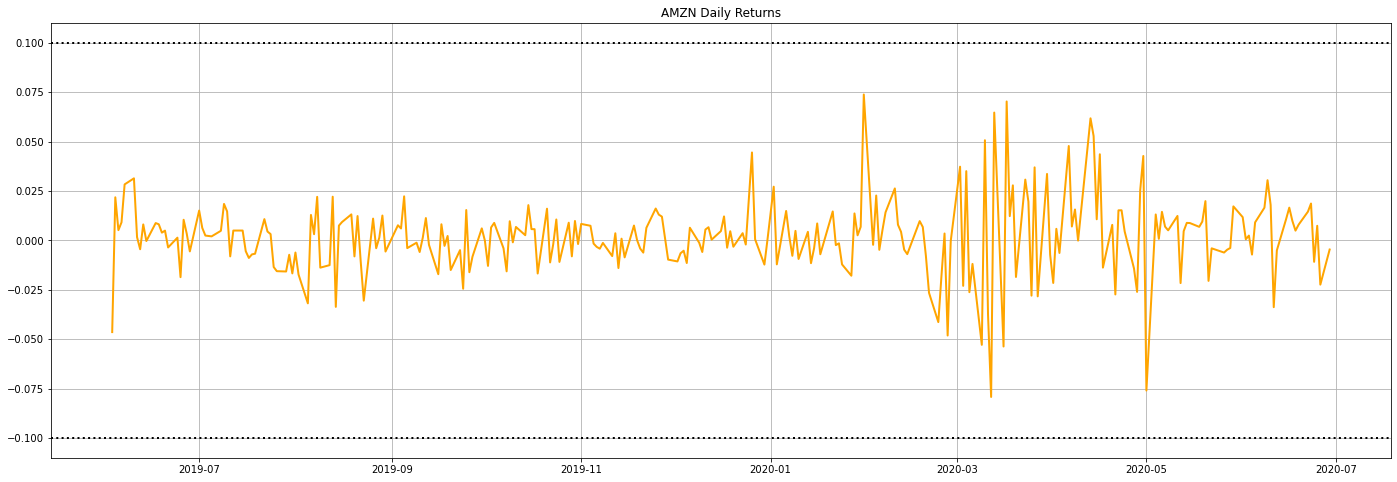

In [5]:

# Visualize AMZN daily returns
plt.plot(returns['AMZN'], color='orange')
plt.axhline(y=0.10, ls='dotted', color='black')
plt.axhline(y=-0.10, ls='dotted', color='black')
plt.title('AMZN Daily Returns')
plt.grid(True)



Normality Test

In the Parametric VaR, we assumed that the returns are normally distributed. However, in the real world, we know that stock / portfolio returns do not necessarily follow a normal distribution. Let's perform a quick check to determine the normality of the underlying returns and see whether we need to modify our approach in deriving the VaR numbers.

Shapiro

The Shapiro-Wilk test is a test of normality and is used to determine whether or not a sample comes from a normal distribution.

In [6]:
# normality test
stats.shapiro(returns['AMZN']) 

ShapiroResult(statistic=0.9364194273948669, pvalue=1.979616470748624e-09)

Our null hypothesis is that Amazon stock daily returns follows a normal distribution. Since the p-value is smaller than 0.05, we to reject the null hypothesis. We have sufficient evidence to say that the sample data does not come from a normal distribution. This result shouldn’t be surprising as the data comes from an empirical distribution.

Anderson-Darling
Alternatively, we can perform an Anderson-Darling Test. It is a goodness of fit test that measures how well the data fit a specified distribution. This test is most commonly used to determine whether or not the data follow a normal distribution.

In [7]:
# normality test
stats.anderson(returns['AMZN'])

AndersonResult(statistic=4.69003069958427, critical_values=array([0.568, 0.647, 0.776, 0.905, 1.077]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

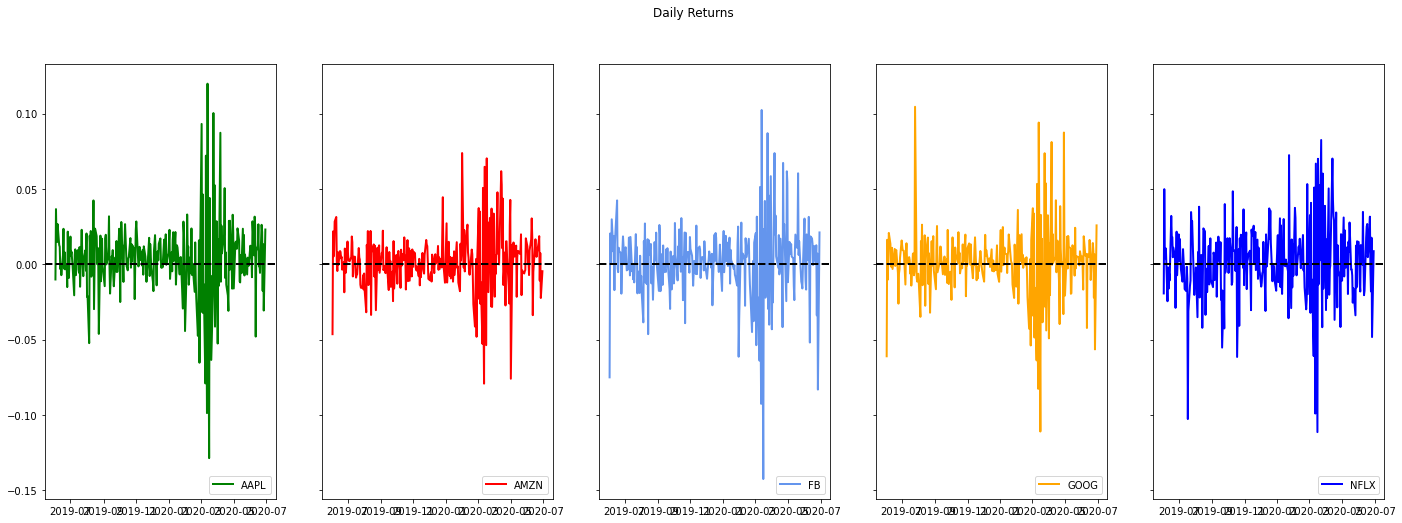

In [8]:
# Visualize daily returns
fig, ax = plt.subplots(1,len(df.columns), sharey=True) 
label, color = df.columns, ['green', 'red', 'cornflowerblue', 'orange', 'blue']

for i in range(len(df.columns)):
    ax[i].plot(returns.iloc[:,i], label=label[i], color=color[i]) 
    ax[i].axhline(y=0, color='k', linestyle='--') 
    ax[i].legend(loc=4) 

fig.suptitle('Daily Returns'); 


<h3 id="Parametric-VaR">Parametric VaR<a class="anchor-link" href="#Parametric-VaR">¶</a></h3><p>The Variance-covariance is a parametric method which assumes (almost always) that the returns are normally distributed. In this method, we first calculate the mean and standard deviation of the returns to derive the risk metric. Based on the assumption of normality, we can generalise,
<br/><br/>
$$ VaR = position * (\mu - z * \sigma) $$</p>
<table>
<thead><tr>
<th style="text-align:left">Confidence Level</th>
<th style="text-align:left">Value At Risk     </th>
</tr>
</thead>
<tbody>
<tr>
<td style="text-align:left"><code>90%</code></td>
<td style="text-align:left">$\mu$ - $1.29$ * $\sigma$ </td>
</tr>
<tr>
<td style="text-align:left"><code>95%</code></td>
<td style="text-align:left">$\mu$ - $1.64$ * $\sigma$             </td>
</tr>
<tr>
<td style="text-align:left"><code>99%</code></td>
<td style="text-align:left">$\mu$ - $2.33$ * $\sigma$             </td>
</tr>
</tbody>
</table>
<p>where, $\mu$ is the return, $\sigma$ is the volatility and $z$ is the number of standard deviation from the mean.</p>


In [9]:

# Calculate mean and standard deviation 
mean = np.mean(returns['AMZN'])
stdev = np.std(returns['AMZN'])

# Calculate VaR at difference confidence level
VaR_90 = norm.ppf(1-0.90,mean,stdev)
VaR_95 = norm.ppf(1-0.95,mean,stdev) #norm.ppf(0.05)
VaR_99 = norm.ppf(1-0.99,mean,stdev)



In [10]:

# Ouput results in tabular format
table = [['90%', VaR_90],['95%', VaR_95],['99%', VaR_99] ]
header = ['Confidence Level', 'Value At Risk']
print(tabulate(table,headers=header))



Confidence Level      Value At Risk
------------------  ---------------
90%                      -0.0231096
95%                      -0.0301439
99%                      -0.043339



<p>Lets now define a VaR function so that we can use it calculate it for individual stocks</p>


In [11]:
# Plot for Value-At-Risk
def plot_var():

    # Hard coded for 95% confidence limit
    
    # Specify confidence level
    confidence_level = 0.95

    # Standard deviation
    z = norm.ppf(1-confidence_level)

    # Specify x ranges for plotting
    x = np.arange(-6,6,0.1)
    x2 = np.arange(-6,z,1/40.)

    # Figure text for annotation
    note1 ='Red area to the left of the'
    note2 ='dotted red line reprsesents'
    note3 ='5% of the total area'
    note4 ='The curve represents a profit/loss'
    note5 ='density function. The 5% VaR is'
    note6 ='1.64 standard deviation from the mean'

    # Set figure size
    plt.figure(figsize=(8, 6))

    # Plot probability density function
    plt.plot(x, norm.pdf(x, 0, 1), color='orange')   #x 数据范围，均值，标准差

    plt.ylim(0,0.5) #取y的范围

    # Plot vertical line at confidence limit
    plt.axvline(x=z, ymin=0, ymax = 1, linewidth=2, ls='dotted', color='red')

    # Fill the left tail from confidence limit
    plt.fill_between(x2,norm.pdf(x2, 0, 1), color='red') #填充颜色 数据范围为x2

    # Annotate with notes 写notes的位置，0.14是段落开始的y轴，0.5是段落开始的x轴
    plt.figtext(0.14,0.5,note1)
    plt.figtext(0.14,0.47,note2)
    plt.figtext(0.14,0.44,note3)

    plt.figtext(0.5,0.85,note4)
    plt.figtext(0.5,0.82,note5)
    plt.figtext(0.5,0.79,note6)

    # Annotate and plot title
    plt.annotate("", xy=(-2.5,0.08), xytext=(-2.5,0.18), arrowprops=dict(facecolor='red',shrink=0.001)) #facecolor箭头颜色，shrink箭头尖长度
    plt.annotate('z = '+str(np.around(z,2)), xy=(-1.5,0.05)) #画x=-1.64
    plt.title("VaR at 95% confidence level")


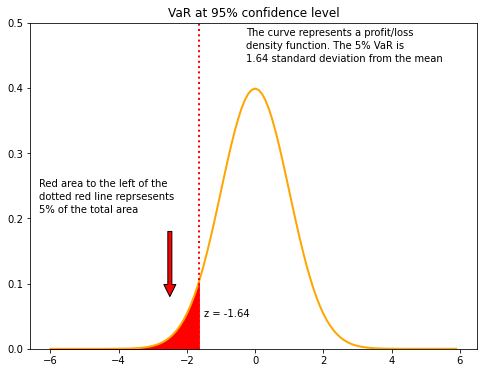

In [12]:
# Visualize VaR at 95% confidence level
plot_var()

In [13]:

# VaR function
def VaR(symbol, cl=0.95):
    mean = np.mean(returns[symbol])
    stdev = np.std(returns[symbol])
    
    return np.around(100*norm.ppf(1-cl,mean,stdev),4)



In [14]:

# VaR for stocks
print('VaR for FAANG Stocks')
print('---'*11)
[print(f'VaR at 95% CL for {stock:4} : {VaR(stock)}%') for stock in df.columns][0]



VaR for FAANG Stocks
---------------------------------
VaR at 95% CL for AAPL : -3.7834%
VaR at 95% CL for AMZN : -3.0144%
VaR at 95% CL for FB   : -4.0193%
VaR at 95% CL for GOOG : -3.606%
VaR at 95% CL for NFLX : -4.1049%


In [ ]:

# Visualize VaR at 95% confidence level




<p>Now, let's assume that we have 1,000 shares of AMZN's stock on April 29, 2020. What is the maximum loss next day with a confidence level of 99%?</p>


In [15]:

num_of_shares = 1000
price = df['AMZN'].iloc[-1]
position = num_of_shares * price 

amzn_var = position * VaR_99

print(f'Amazon Holding Value: {position}')
print(f'Amazon VaR at 99% confidence level is: {amzn_var}')



Amazon Holding Value: 2680379.8828125
Amazon VaR at 99% confidence level is: -116164.85481107555



<p>VaR can also be calculated using the above formula at 99% confidence level.</p>


In [16]:

# VaR calculation by appling direct formulae
position * (mean + norm.ppf(1-0.99) * stdev)         # mean-2.33*stdev



-116164.85481107555


<h3 id="Scaling-VaR">Scaling VaR<a class="anchor-link" href="#Scaling-VaR">¶</a></h3><p>Now, let's calculate VaR over a 5-day period. To scale it, multiply by square root of time.
<br/><br/>
$$ VaR = position * (\mu - z * \sigma) * \sqrt{T}$$</p>
<p>where, $T$ is the horizon or forecast period.</p>


In [17]:

forecast_days = 5
f_VaR_90 = VaR_90*np.sqrt(forecast_days)
f_VaR_95 = VaR_95*np.sqrt(forecast_days)
f_VaR_99 = VaR_99*np.sqrt(forecast_days)



In [18]:

ftable = [['90%', f_VaR_90],['95%', f_VaR_95],['99%', f_VaR_99] ]
fheader = ['Confidence Level', '5-Day Forecast Value At Risk']
print(tabulate(ftable,headers=fheader))



Confidence Level      5-Day Forecast Value At Risk
------------------  ------------------------------
90%                                     -0.0516747
95%                                     -0.0674038
99%                                     -0.0969088



<p>Let's now calculate AMZN VaR over a 5-day period with a confidence level of 99%</p>


In [19]:

amzn_var_5days = position * f_VaR_99

print(f'Amazon Holding Value: {position}')
print(f'Amazon VaR at 99% confidence level is: {amzn_var_5days}')



Amazon Holding Value: 2680379.8828125
Amazon VaR at 99% confidence level is: -259752.51195395843


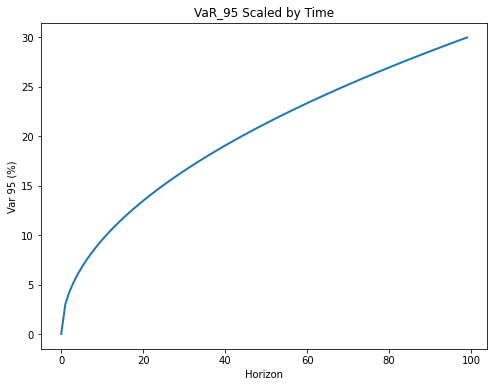

In [20]:

# Scaled VaR over different time horizon
plt.figure(figsize=(8,6))
plt.plot(range(100),[-100*VaR_95*np.sqrt(x) for x in range(100)])
plt.xlabel('Horizon')
plt.ylabel('Var 95 (%)')
plt.title('VaR_95 Scaled by Time');




<h3 id="Historical-VaR">Historical VaR<a class="anchor-link" href="#Historical-VaR">¶</a></h3><p>Asset returns do not necessarily follow a normal distribution. An alternative is to use sorted returns to evaluate a VaR. This method uses historical data where returns are sorted in ascending order to calculate maximum possible loss for a given confidence level.</p>


In [21]:

# Use quantile function for Historical VaR
hVaR_90 = returns['AMZN'].quantile(0.10)
hVaR_95 = returns['AMZN'].quantile(0.05)
hVaR_99 = returns['AMZN'].quantile(0.01)



In [22]:

htable = [['90%', hVaR_90],['95%', hVaR_95],['99%', hVaR_99]]
print(tabulate(htable,headers=header))



Confidence Level      Value At Risk
------------------  ---------------
90%                      -0.0178278
95%                      -0.0276336
99%                      -0.0530985



<h3 id="Expected-Short-Fall">Expected Short Fall<a class="anchor-link" href="#Expected-Short-Fall">¶</a></h3><p>VaR is a reasonable measure of risk if assumption of normality holds. Else, we might underestimate the risk if we observe a fat tail or overestimate the risk if tail is thinner. Expected shortfall or Conditional Value at Risk - <strong>CVaR</strong> - is an estimate of expected shortfall sustained in the worst 1 - x% of scenarios. It is defined as the average loss based on the returns that are lower than the VaR threshold. Assume that we have <em><code>n</code></em> return observations, then the expected shortfall is
<br/><br/>
$$ CVaR = \frac 1 n * \sum_{i=1}^{n} R_i[R \leq hVaR_{cl}]$$</p>
<p>where, $R$ is returns, $hVaR$ is historical VaR and $cl$ is the confidence level.</p>


In [23]:

# Calculate CVar
CVaR_90 = returns['AMZN'][returns['AMZN']<=hVaR_90].mean()
CVaR_95 = returns['AMZN'][returns['AMZN']<=hVaR_95].mean()
CVaR_99 = returns['AMZN'][returns['AMZN']<=hVaR_99].mean()



In [24]:

ctable = [['90%', CVaR_90],['95%', CVaR_95],['99%', CVaR_99] ]
cheader = ['Confidence Level', 'Conditional Value At Risk']
print(tabulate(ctable,headers=cheader))



Confidence Level      Conditional Value At Risk
------------------  ---------------------------
90%                                  -0.0333641
95%                                  -0.0443762
99%                                  -0.0696308



<h3 id="MonteCarlo-VaR">MonteCarlo VaR<a class="anchor-link" href="#MonteCarlo-VaR">¶</a></h3><p>The Monte Carlo simulation approach has a number of similarities to historical simulation. It allows us to use actual historical distributions rather than having to assume normal returns. As returns are assumed to follow a normal distribution, we could generate <em><code>n</code></em> simulated returns with the same mean and standard deviation (derived from the daily returns) and then sorted in ascending order to calculate maximum possible loss for a given confidence level.</p>


In [25]:

# Set seed for reproducibility
np.random.seed(12345)

# Number of simulations
n_sims = 5000

# Simulate returns and sort
sim_returns = np.random.normal(mean, stdev, n_sims)

# Use percentile function for MCVaR
MCVaR_90 = np.percentile(sim_returns,10)
MCVaR_95 = np.percentile(sim_returns, 5)
MCVaR_99 = np.percentile(sim_returns,1)



In [26]:

mctable = [['90%', MCVaR_90],['95%', MCVaR_95],['99%', MCVaR_99]]
print(tabulate(mctable,headers=header))



Confidence Level      Value At Risk
------------------  ---------------
90%                      -0.0228081
95%                      -0.0298137
99%                      -0.0423753



<h2 id="Portfolio-VaR">Portfolio VaR<a class="anchor-link" href="#Portfolio-VaR">¶</a></h2><p>If we know the returns and volatilities of all the assets in the portfolio, we can calculate the VaR for the whole portfolio. We will now derive VaR of an equal weighted portfolio of FAANG stocks.</p>



<h3 id="Assign-Weights">Assign Weights<a class="anchor-link" href="#Assign-Weights">¶</a></h3>


In [27]:

wts = np.array([0.2,0.2,0.2,0.2,0.2])[:,np.newaxis]
wts



array([[0.2],
       [0.2],
       [0.2],
       [0.2],
       [0.2]])


<h3 id="Portfolio-return">Portfolio return<a class="anchor-link" href="#Portfolio-return">¶</a></h3>


In [28]:

# Stock returns
returns[:5]



,AAPL,AMZN,FB,GOOG,NFLX
Date,,,,,
2019-06-03,-0.010110,-0.046409,-0.075055,-0.061071,-0.019372
2019-06-04,0.036584,0.021782,0.020408,0.016232,0.049817
2019-06-05,0.016143,0.005169,0.004000,-0.010284,0.006593
2019-06-06,0.014682,0.009123,0.000951,0.002034,0.003936
2019-06-07,0.026617,0.028312,0.029822,0.020779,0.010472


In [29]:

port_ret = np.dot(returns,wts)
port_ret.flatten()



array([-4.24035803e-02,  2.89646659e-02,  4.32417750e-03,  6.14511994e-03,
        2.32005878e-02,  8.30669094e-03,  5.67056819e-03, -8.53648383e-03,
        5.29743937e-03,  4.72600084e-05,  1.91425646e-02,  1.14987767e-02,
        2.49943762e-03,  7.35797721e-03,  4.37150640e-03,  1.45603787e-03,
       -2.16782703e-02,  5.00765639e-03,  6.19672020e-03,  2.04429533e-04,
        1.38012812e-02,  7.37039316e-03,  9.60870407e-03,  5.87787360e-04,
       -8.80662805e-03,  1.19541831e-02,  1.17857206e-02, -4.68945671e-03,
        2.97357064e-03, -6.77599811e-04, -1.62763989e-03, -8.09785175e-03,
       -2.07052169e-02, -1.57982053e-02,  9.27958771e-03,  1.78833048e-03,
        8.20329333e-03, -3.78008619e-03,  2.32279967e-02, -8.69071535e-03,
       -7.56382471e-03, -5.30120813e-03, -1.05220407e-02, -1.44437893e-02,
       -3.85630548e-02,  1.40833207e-02,  3.31372286e-04,  2.71065864e-02,
       -1.40393593e-02, -6.66411703e-03,  2.09837083e-02, -3.59016233e-02,
        1.97200706e-03,  

In [30]:

port_mean = port_ret.mean()
port_mean



0.0016547264695402394


<h3 id="Portfolio-Volatility">Portfolio Volatility<a class="anchor-link" href="#Portfolio-Volatility">¶</a></h3>


In [31]:

# Covariance matrix
returns.cov()



,AAPL,AMZN,FB,GOOG,NFLX
AAPL,0.000619,0.000332,0.000485,0.000461,0.000352
AMZN,0.000332,0.000376,0.000331,0.000299,0.000325
FB,0.000485,0.000331,0.000633,0.000462,0.000359
GOOG,0.000461,0.000299,0.000462,0.000513,0.000328
NFLX,0.000352,0.000325,0.000359,0.000328,0.000666


In [32]:

# Portfolio volatility
port_stdev = np.sqrt(multi_dot([wts.T, returns.cov(), wts]))
port_stdev.flatten()[0]



0.02026960368901688


<h3 id="Portfolio-Position">Portfolio Position<a class="anchor-link" href="#Portfolio-Position">¶</a></h3>


In [33]:

# Portfolio Position
port_pos = (df.iloc[-1] * num_of_shares).sum()
port_pos



4833222.099304199

In [34]:

# Calculate Portfolio VaR at difference confidence level
pVaR_90 = norm.ppf(1-0.90,port_mean,port_stdev).flatten()[0]
pVaR_95 = norm.ppf(1-0.95,port_mean,port_stdev).flatten()[0]
pVaR_99 = norm.ppf(1-0.99,port_mean,port_stdev).flatten()[0]



In [35]:

pVaR_95



-0.03168580467520811


<h3 id="Portfolio-VaR">Portfolio VaR<a class="anchor-link" href="#Portfolio-VaR">¶</a></h3>


In [36]:

# Ouput results in tabular format
ptable = [['90%', pVaR_90],['95%', pVaR_95],['99%', pVaR_99]]
header = ['Confidence Level', 'Value At Risk']
print(tabulate(ptable,headers=header))



Confidence Level      Value At Risk
------------------  ---------------
90%                      -0.0243218
95%                      -0.0316858
99%                      -0.0454994



<p>Let's now compare the portfolio VaR numbers with that of the individual stocks</p>


In [37]:

# Iterate over symbols
for stock in df.columns:
    pos = df[stock].iloc[-1] * num_of_shares
    pvar = pos * VaR(stock)
    
    print(f'{stock} Holding Value: {pos:0.4}') 
    print(f'{stock} VaR at 95% confidence level: {pvar:0.4}')
    print()

print(f'Portfolio Holding Value: {port_pos:0.4}')
print(f'Portoflio VaR at 95% confidence level: {port_pos * pVaR_95:0.4}')



AAPL Holding Value: 8.999e+04
AAPL VaR at 95% confidence level: -3.405e+05

AMZN Holding Value: 2.68e+06
AMZN VaR at 95% confidence level: -8.08e+06

FB Holding Value: 2.206e+05
FB VaR at 95% confidence level: -8.868e+05

GOOG Holding Value: 1.395e+06
GOOG VaR at 95% confidence level: -5.03e+06

NFLX Holding Value: 4.472e+05
NFLX VaR at 95% confidence level: -1.836e+06

Portfolio Holding Value: 4.833e+06
Portoflio VaR at 95% confidence level: -1.531e+05



<p>The VaR for the current portfolio of $\$ 4.6$ million is \$109,356, which is much lesser than the individual VaR numbers. This signifies the effect of diversification by selecting different stocks.</p>



<h1 id="References">References<a class="anchor-link" href="#References">¶</a></h1><ul>
<li><p>Numpy documentation <a href="https://docs.scipy.org/doc/numpy/">https://docs.scipy.org/doc/numpy/</a></p>
</li>
<li><p>Scipy documentation <a href="https://docs.scipy.org/doc/scipy/reference/">https://docs.scipy.org/doc/scipy/reference/</a></p>
</li>
<li><p>Paul Wilmott (2007), Paul Wilmott introduces Quantitative Finance</p>
</li>
</ul>
